# Interpreting a neural network for regulatory compliance in banking

Banca Virtuosa, a leading financial institution, has identified the need to improve the transparency and comprehensibility of artificial intelligence models used in its systems. To achieve this goal, Banca Virtuosa has launched a project aimed at implementing Explainable AI (XAI) techniques, in accordance with current banking transparency regulations.

Currently, Banca Virtuosa uses pre-trained classification models to analyze and classify critical financial data. However, the lack of transparency in the decisions of these models can compromise customer trust and limit the bank's ability to improve its systems in a targeted manner. Identifying and correcting classification errors is crucial to ensuring accuracy and reliability in the services offered.

**Solution benefits**

1. **Transparency in model decisions:** by implementing XAI techniques such as Grad-CAM, LIME, SHAP, Integrated Gradients, and Occlusion Maps, Banca Virtuosa will be able to generate saliency maps that visually show which elements influence model decisions. This increase in transparency will improve customer and stakeholder trust, demonstrating the reliability and explainability of the classification system's operations.

2. **Continuous performance improvement:** by analyzing saliency maps, Banca Virtuosa will be able to accurately identify areas where the model makes errors, both in correct and incorrect classifications. This detailed analysis will allow for targeted improvements to the model, optimizing its performance and reducing the risk of data misinterpretation.

3. **Regulatory compliance:** the project will ensure that AI models' decisions are explainable, in line with existing regulatory requirements. Transparency of AI decisions is essential for regulatory compliance and corporate governance, particularly in regulated sectors such as finance.

4. **Promotion of innovation:** the use of advanced XAI techniques within Banca Virtuosa will promote innovation in the field of artificial intelligence. This will strengthen the bank's position as a pioneer in the adoption of advanced technologies, allowing customers to be offered increasingly sophisticated and reliable solutions.

**Project details**

1. **Phase 1: using a pre-trained classification model**
    - **Model:** use a pre-trained model, such as DenseNet, from the torchvision library.
    - **Dataset:** apply the model to an image dataset, such as MNIST, to explore its classification decisions.

2. **Phase 2: generation of saliency maps**
    - **XAI techniques:** implement techniques such as Grad-CAM, LIME, SHAP, Integrated Gradients, and Occlusion Maps to generate model saliency maps.

3. **Phase 3: final report**
    - **Dataset description:** detail the origin, structure, and characteristics of the dataset used.
    - **Saliency map analysis:** compare saliency maps for correct and incorrect classes to identify and understand model errors.
    - **Explainable system (optional):** describe a fully explainable system that could perform the same classification, offering further insights into model decisions.

**Project goals**

1. **Model understanding:** use XAI techniques to gain a deep understanding of the inner workings of the pre-trained model.

2. **Decision visualization:** clearly and interpretably visualize which elements influence model decisions through saliency maps.

3. **Error identification:** analyze saliency maps to identify and understand model errors, distinguishing between correct and incorrect classifications.

4. **Creating explainable systems:** if possible, develop or describe a fully explainable system that can perform the same classification, providing further insights into model decisions.

**Project motivation**

Explainable AI techniques are essential for Banca Virtuosa to improve transparency, optimize model performance, and ensure regulatory compliance. With this project, the bank aims to strengthen customer trust, improve operational efficiency, and promote innovation in artificial intelligence.

# Disclaimer

*Due to the nature of the tasks performed within the project, with particular reference to the training of the models presented, the resources made available by Google Colab proved to be insufficient. For this reason, it was necessary to upgrade to Google Colab Pro, which allowed access to the following resources:*

- GPU: A100
- System RAM: 84GB
- GPU RAM: 40GB
- DISK SPACE: 113GB

*The user is then encouraged to take this aspect into consideration before executing the project (or portions of it), as it may be too burdensome for an insufficiently equipped system.*

# Environment set up

In [ ]:
# Install libraries
!pip install grad-cam
!pip install captum
!pip install lime
!pip install shap

In [ ]:
# Library import
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from sklearn.metrics import classification_report, confusion_matrix
from pytorch_grad_cam.utils.image import show_cam_on_image
from captum.attr import IntegratedGradients, Occlusion
from torch.utils.data import DataLoader, random_split
from skimage.segmentation import mark_boundaries
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
import matplotlib.pyplot as plt
from collections import Counter
from lime import lime_image
import torch.nn as nn
import torchvision
import numpy as np
import warnings
import random
import torch
import json
import shap
import os

# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
# Seed set up to ensure reproducibility
seed = 0

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)

In [ ]:
# Check that the GPU is mounted correctly
torch.cuda.is_available()

True

In [ ]:
# Select the device to run PyTorch tensors and models on, preferring GPU (CUDA) if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Utilities

The following cell defines the project parameters that will be used throughout the notebook for varoius tasks like data loading, model training, and image generation. Here's a breakdown:

* **BATCH_SIZE:** determines the number of samples that will be processed in one go during model training.
* **CLASSES:** list of classes present within the MNIST dataset.
* **OUT_FEATURES:** indicates the number of distinct categories or classes that the image classification models will predict.
* **LEARNING_RATE:** hyperparameter that controls how much the model's weights are adjusted with respect to the loss gradient during training.
* **EPOCHS:** number of times the entire training dataset will be passed forward and backward through the neural network.
* **SAMPLES:** Numbero of sample to use for the explanation phase.

In [ ]:
# Project parameters
BATCH_SIZE = 32
CLASSES = 0 # TBD
OUT_FEATURES = 0 # TBD
LEARNING_RATE = 0.0001
EPOCHS = 5
SAMPLES = 10

The function **get_class_sample_indices** iterates through a given dataset to find the index of one sample for each specified class. It's particularly useful to quickly retrieve a representative image from each category for tasks like visualization or analysis.

In [ ]:
def get_class_sample_indices(dataset, classes):

    # Initialize a dictionary to store the first index found for each class
    class_sample_indices = dict()

    # Iterate through the dataset to locate representative samples for each class
    for i, (_, label) in enumerate(dataset):
        # Map the current index to the label if it is a target class and not yet recorded
        if label not in class_sample_indices and label in classes:
            class_sample_indices[label] = i

        # Terminate the search early once an index for every requested class is found
        if len(class_sample_indices) == len(classes):
            break

    # Return the dictionary sorted by class label to ensure consistent analysis output
    return dict(sorted(class_sample_indices.items()))

The function **image_preview** is designed to display a sample of five images from a given dataset and adds a title for the plot.

In [ ]:
def image_preview(dataset, dataset_name):

    # Retrieve the first index for every class to ensure a comprehensive preview
    index_dict = get_class_sample_indices(dataset, [i for i in range(len(dataset.classes))])

    # Initialize a grid layout to accommodate ten distinct class samples
    fig, axes = plt.subplots(2, 5, figsize=(13, 4))

    # Flatten the axes for straightforward iteration through the grid cells
    axes = axes.flatten()

    for i_idx, data_idx in enumerate(index_dict.values()):
        # Fetch the image tensor and its corresponding ground truth label
        image, label = dataset[data_idx]

        # Reverse the normalization transform to restore the original pixel intensity
        image_display = image * 0.5 + 0.5

        # Reorder dimensions from PyTorch format to Matplotlib-compatible RGB format
        image_display = image_display.permute(1, 2, 0)

        # Ensure pixel values remain within the valid [0, 1] range for visual rendering
        image_display = torch.clamp(image_display, 0, 1)

        # Render the sample image alongside its label while hiding coordinate axes
        axes[i_idx].imshow(image_display.numpy())
        axes[i_idx].set_title(f'Label: {label}')
        axes[i_idx].axis('off')

    # Finalize the figure with a descriptive title and optimized spacing
    plt.suptitle(f'Sample images from {dataset_name} dataset')
    plt.tight_layout()
    plt.show()

 The following code defines the **classes_distribution** function, wich is designed to visualize the distribution of classes within a given dataset.

In [ ]:
def classes_distribution(dataset, dataset_name):

    # Extract all target labels to evaluate the balance of the dataset
    label_dt = [label for _, label in dataset]

    # Calculate the total frequency of each class using a Counter object
    label_counts = Counter(label_dt)

    # Sort labels numerically to ensure the bar chart follows a logical progression
    sorted_labels = sorted(label_counts.keys())
    sorted_counts = [label_counts[label] for label in sorted_labels]

    # Initialize the bar chart with a clear, readable scale
    plt.figure(figsize=(10, 6))
    bars = plt.bar(sorted_labels, sorted_counts, color='skyblue')

    # Annotate each bar with its exact count for precise data verification
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 10, yval, ha='center', va='bottom', fontsize=9)

    # Configure plot metadata and visual aids for better interpretability
    plt.xlabel('Digit class')
    plt.ylabel('Number of samples')
    plt.title(f'Class distribution in {dataset_name} dataset')
    plt.xticks(sorted_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

This cell defines the functions for training and evaluating image classification models:

* The **densenet121_model** function is designed to leverage the densenet pre-trained models, adapt it for a specific classification task and then train it.

* The **show_classification_report** function generate and print the classification report for the trained the model.

* The **show_training_history** function shows the model training history (*training loss* and *validation loss*).

* The **show_confusion_matrix** function plot the confusion matrix of the model on a given test dataset.

In [ ]:
def densenet121_model(trainval_dataset, epochs, lr, model_name):

    # Define the proportions for an 80-20 split between training and validation sets
    train_size = int(0.8 * len(trainval_dataset))
    val_size = len(trainval_dataset) - train_size

    # Partition the dataset randomly to ensure unbiased model evaluation
    train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

    # Initialize DataLoaders to manage batching, shuffling, and memory efficiency
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize a pre-trained DenseNet121 architecture on the active compute device
    model = torchvision.models.densenet121(pretrained=True).to(device)

    # Reconfigure the final linear layer to match the required number of output classes
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, OUT_FEATURES).to(device)

    # Setup the optimization objective and the Adam optimizer for weight updates
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'val_loss': []}

    print(f'Training started for: {model_name}')
    for epoch in range(epochs):

        # Prepare the model for the training phase by enabling gradient tracking
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()                   # Reset gradients from the previous batch
            outputs = model(inputs)                 # Execute the forward pass
            loss = criterion(outputs, labels)       # Compute the batch loss
            loss.backward()                         # Calculate gradients via backpropagation
            optimizer.step()                        # Update model parameters
            running_loss += loss.item()

        # Record the average training loss to monitor convergence over time
        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Transition to evaluation mode to disable dropout and batch normalization updates
        model.eval()
        val_loss = 0

        # Perform inference on the validation set without computing gradients
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Log the validation loss to detect potential overfitting during training
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f'Epoch {epoch + 1}/{epochs} - Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}')

    return model, history

def show_training_history(model_history, model_name):

    # Initialize a figure to visualize the loss trajectory across the training duration
    plt.figure(figsize=(11, 6))

    # Plot both training and validation metrics to identify potential overfitting or underfitting
    plt.plot(model_history['train_loss'], label='Train loss')
    plt.plot(model_history['val_loss'], label='Validation loss')

    # Configure descriptive titles and axis labels for clear technical communication
    plt.title(f'{model_name} - Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Add a legend and grid to facilitate precise comparison between the two curves
    plt.legend()
    plt.grid(True)

    # Render the final plot for inclusion in the performance report
    plt.show()

def show_classification_report(model, data_loader, model_name):

    # Transition to evaluation mode to ensure consistent model behavior during inference
    model.eval()
    y_true = list()
    y_pred = list()

    # Perform inference without tracking gradients to optimize memory usage and speed
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Transfer the input batch to the active compute device
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Identify the class with the highest probability for each sample in the batch
            preds = torch.argmax(outputs, dim=1).cpu().tolist()

            # Aggregate predictions and true labels for final metric calculation
            y_pred.extend(preds)
            y_true.extend(labels.tolist())

    # Generate and display the statistical performance breakdown for the model
    print(f'{model_name} - Classification report:')
    print(classification_report(y_true, y_pred, target_names=CLASSES))

def show_confusion_matrix(model, data_loader, model_name):

    # Transition the model to evaluation mode for consistent inference behavior
    model.eval()
    y_true = list()
    y_pred = list()

    # Execute a forward pass without gradient tracking to optimize resource usage
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Extract the predicted class indices by identifying the maximum logit value
            preds = torch.argmax(outputs, dim=1).cpu().tolist()

            # Consolidate predictions and actual labels for comparative analysis
            y_pred.extend(preds)
            y_true.extend(labels.tolist())

    # Compute the raw confusion matrix to evaluate inter-class error patterns
    cm = confusion_matrix(y_true, y_pred)

    # Initialize the heatmap visualization with a clear color gradient
    plt.figure(figsize=(11, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion matrix')
    plt.colorbar()

    # Configure the axes with human-readable class labels for better interpretability
    tick_marks = np.arange(len(CLASSES))
    plt.xticks(tick_marks, CLASSES, rotation=90)
    plt.yticks(tick_marks, CLASSES)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Overlay the frequency counts on the matrix cells using dynamic contrast for legibility
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')

    # Finalize the layout to ensure all elements are properly aligned for the report
    plt.tight_layout()
    plt.show()

The **get_sample_to_analyze** function is used for the XAI study phase and it's used to retrive some samples for testing purposes. The samples are saved in a list of tuples where, for each element are stored the *image*, the *image label* and the *predicted label*.

In [ ]:
def get_samples_to_analyze(model, num_sample):

    # Initialize separate collections to categorize model predictions during the evaluation pass
    all_wrong_samples = list()
    all_true_samples = list()

    # Set the model to evaluation mode to ensure deterministic behavior during inference
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Generate class predictions by identifying the index of the highest logit output
            outputs = model(inputs.to(device))
            preds = outputs.argmax(1).cpu()

            # Partition each image into the appropriate list based on prediction accuracy
            for img, true_label, pred_label in zip(inputs, labels, preds):
                if pred_label != true_label:
                    all_wrong_samples.append((img, true_label, pred_label))
                else:
                    all_true_samples.append((img, true_label, pred_label))

    # Randomly select a subset of failures to investigate the root causes of misclassification
    wrong_samples = random.sample(all_wrong_samples, min(num_sample // 2, len(all_wrong_samples)))

    # Randomly select successful predictions to verify that the model relies on valid features
    true_samples = random.sample(all_true_samples, min(num_sample // 2, len(all_true_samples)))

    # Consolidate the diverse samples into a single list for downstream XAI processing
    all_samples = wrong_samples + true_samples

    print(f'Successfully sampled {len(all_samples)} images for further analysis.')

    return all_samples

The following cell defines five important functions for interpreting the neural network model:

* **grad_cam_analysis:** this function implements the **Grad-CAM** (**Gradient-weighted Class Activation Mapping**) technique. For each image in the samples, it identifies the final convolutional layer of your model and generates a grayscale heatmap. This heatmap highlights the regions in the input image that were most important for the model's prediction of a specific class. It then overlays this heatmap on the original image, displaying both side-by-side to visually show where the model is looking when making a decision.

* **lime_analysis:** this function uses **LIME** (**Local Interpretable Model-agnostic Explanations**). For each sample, LIME perturbs the input image multiple times and observes how the model's prediction changes. It then trains a simpler, interpretable model locally around the prediction to explain the black-box model's behavior. The output visualizes the superpixels that most positively influenced the predicted class, showing which segments of the image are crucial.

* **shap_analysis:** this function performs **SHAP** (**SHapley Additive exPlanations**) analysis using `shap.GradientExplainer`. For each sample, SHAP computes "*Shapley values*", which quantify the contribution of each pixel (or feature) to the model's prediction for a specific class. It uses a background_data set as a reference. The function generates a heatmap where different colors or intensities indicate whether a pixel contributes positively or negatively to the prediction, revealing which parts of the image are driving the model's output.

* **integrated_gradients_analysis:** this function uses **Integrated Gradients**, an axiomatic attribution method. For each image in your samples, it calculates feature attribution scores by approximating the integral of gradients along a path from a baseline image to the actual input image. This process determines how much each pixel contributes to the model's prediction for a given class. The function then generates and displays a heatmap that highlights these influential pixels, showing where the model focuses its attention.

* **occlusion_analysis:** this function implements **Occlusion Maps***, a perturbation-based technique. For each sample, it systematically occludes (blocks out) parts of the input image with a sliding window and measures the change in the model's prediction confidence. If occluding a specific region significantly reduces the confidence for the predicted class, that region is considered important. The function then generates a heatmap where warmer colors indicate regions whose occlusion had a higher impact on the model's decision, thus revealing which parts of the image are critical for the prediction.

In [ ]:
def grad_cam_analysis(model, samples):

    # Identify the final convolutional layer to extract the high-level spatial features
    target_layers = [model.features[-1]]

    # Initialize the Grad-CAM object with the model and target layers for activation mapping
    cam = GradCAM(model=model, target_layers=target_layers)

    for img, true_label, pred_label in samples:
        # Prepare the image by adding a batch dimension and moving it to the active device
        input_tensor = img.unsqueeze(0).to(device)

        # Generate the grayscale saliency map targeted at the predicted class index
        grayscale_cam = cam(
            input_tensor=input_tensor,
            targets=[ClassifierOutputTarget(pred_label)])

        # Prepare the original image for visualization by restoring dimensions and clipping pixel values
        rgb_img = img.permute(1, 2, 0).cpu().numpy()
        rgb_img = np.clip(rgb_img, 0, 1)

        # Overlay the computed heatmap onto the original input to highlight influential regions
        visualization = show_cam_on_image(
            rgb_img,
            grayscale_cam[0, :],
            use_rgb=True)

        # Construct a side-by-side comparison to evaluate the model's focus against the ground truth
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

        ax1.imshow(rgb_img)
        ax1.set_title(f'Original image (label: {true_label.item()})')
        ax1.axis('off')

        ax2.imshow(visualization)
        ax2.set_title(f'Grad-CAM explanation (prediction: {pred_label.item()})')
        ax2.axis('off')

        plt.show()

def lime_analysis(models, samples):

    # Initialize the LIME image explainer to perform local surrogate model analysis
    explainer = lime_image.LimeImageExplainer()

    for img, true_label, pred_label in samples:
        # Reorder dimensions to H x W x C format as required by the LIME library
        np_img = img.permute(1, 2, 0).numpy()

        # Execute the perturbation process to observe how the model reacts to masked image segments
        explanation = explainer.explain_instance(
            np_img,
            classifier_fn=lambda x: densenet_model(
                torch.tensor(x).permute(0, 3, 1, 2).float().to(device)
            ).softmax(1).cpu().detach().numpy(),
            top_labels=10,
            num_samples=1000)

        # Prepare the original image for plotting by restoring the pixel intensity range
        original_img = img.permute(1, 2, 0).cpu().numpy()
        original_img = np.clip(original_img, 0, 1)

        # Extract the superpixels that contributed most positively to the predicted class
        temp, mask = explanation.get_image_and_mask(
            pred_label.item(),
            positive_only=True,
            num_features=5,
            hide_rest=False)

        # Visualize the original input alongside the LIME superpixel boundaries for comparative review
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

        ax1.imshow(original_img)
        ax1.set_title(f'Original image (label: {true_label.item()})')
        ax1.axis('off')

        # Overlay the boundaries of the top superpixels on the input image
        ax2.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        ax2.set_title(f'LIME explanation (prediction: {pred_label.item()})')
        ax2.axis('off')

        plt.show()

def shap_analysis(model, samples):

    # Construct a background distribution to serve as a reference for the Shapley value calculations
    background_data = torch.stack([test_dataset[i][0] for i in range(50)])

    # Disable in-place ReLU operations to ensure the model's computation graph is compatible with GradientExplainer
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.inplace = False

    # Prepare the model for inference on the active compute device
    model.to(device)
    model.eval()

    # Initialize the explainer by mapping the model against the provided background dataset
    explainer = shap.GradientExplainer(model, background_data.to(device))

    for img, true_label, pred_label in samples:
        # Format the input image with a batch dimension for processing by the explainer
        input_tensor = img.unsqueeze(0).to(device)

        # Compute the raw SHAP values to determine the contribution of each input feature to the output
        shap_values_raw = explainer.shap_values(input_tensor)

        # Parse the attribution output based on whether the result is returned as a list or a multi-dimensional array
        if isinstance(shap_values_raw, list):
            attr = shap_values_raw[pred_label.item()][0]
        else:
            attr = shap_values_raw[0, ..., pred_label.item()]

        # Aggregate multi-channel attributions into a single-channel heatmap for spatial visualization
        if attr.shape[0] == 3:
            heatmap = np.sum(np.abs(attr), axis=0)
        else:
            heatmap = np.sum(np.abs(attr), axis=2)

        # Scale the heatmap values to a standard range to ensure visual consistency across different samples
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        # Restore the original image for plotting by reordering dimensions and clipping intensities
        original_img = img.permute(1, 2, 0).cpu().numpy()
        original_img = np.clip(original_img, 0, 1)

        # Render the original image alongside the SHAP attribution map for a comparative evidence review
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.imshow(original_img)
        ax1.set_title(f'Original image (label: {true_label.item()})')
        ax1.axis('off')

        # Apply a divergent colormap to highlight the intensity of pixel influence on the model's decision
        im2 = ax2.imshow(heatmap, cmap='RdBu_r')
        ax2.set_title(f'SHAP explanation (prediction: {pred_label.item()})')
        ax2.axis('off')

        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
        plt.show()

def integrated_gradients_analysis(model, samples):

    # Transition the model to evaluation mode to ensure consistent gradient behavior
    model.eval()

    # Initialize the Integrated Gradients interpreter to calculate feature attribution scores
    ig = IntegratedGradients(model)

    for img, true_label, pred_label in samples:
        # Include a batch dimension to meet the input requirements of the Captum library
        input_tensors = img.unsqueeze(0).to(device)

        # Approximate the integral of gradients along the path from a baseline to the input image
        attributions = ig.attribute(input_tensors, target=pred_label, n_steps=50)

        # Extract the attribution tensor and transfer it to the CPU for numerical processing
        attr = attributions.squeeze().cpu().detach().numpy()

        # Generate a spatial heatmap by aggregating the absolute influence across all color channels
        heatmap = np.sum(np.abs(attr), axis=0)

        # Apply min-max normalization to enhance the visual contrast of the influential features
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        # Prepare the original image for display by restoring the standard coordinate format and range
        rgb_img = img.permute(1, 2, 0).cpu().numpy()
        rgb_img = np.clip(rgb_img, 0, 1)

        # Construct a side-by-side visualization to audit the model's focus against the original input
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

        ax1.imshow(rgb_img)
        ax1.set_title(f'Original image (label: {true_label.item()})')
        ax1.axis('off')

        # Render the attribution map using a high-contrast colormap to highlight critical pixels
        im2 = ax2.imshow(heatmap, cmap='hot')
        ax2.set_title(f'Integrated Gradients explanation\n(prediction: {pred_label.item()})')
        ax2.axis('off')

        # Add a colorbar to provide a quantitative scale for the feature importance scores
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

def occlusion_analysis(model, samples):

    # Transition the model to evaluation mode to ensure deterministic output during the perturbation process
    model.eval()

    # Initialize the Occlusion interpreter to measure the sensitivity of the prediction to local feature removal
    occlusion = Occlusion(model)

    for img, true_label, pred_label in samples:
        # Append a batch dimension to align with the processing requirements of the occlusion algorithm
        input_img = img.unsqueeze(0).to(device)

        # Compute attributions by sliding a window over the image and measuring the resulting drop in confidence
        attributions = occlusion.attribute(
            input_img,
            target=pred_label.item(),
            strides=(3, 8, 8),
            sliding_window_shapes=(3, 15, 15),
            baselines=0)

        # Transfer the attribution tensor to the CPU and remove dimensions of size one for numerical analysis
        attr = attributions.squeeze().cpu().detach().numpy()

        # Condense multi-channel importance scores into a 2D spatial map using absolute summation
        if attr.ndim == 3:
            attr = np.sum(np.abs(attr), axis=0)

        # Normalize the sensitivity map to a standard range for consistent visual interpretation
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

        # Prepare the original input image for display by restoring the standard coordinate format
        orig = img.permute(1, 2, 0).cpu().numpy()
        orig = np.clip(orig, 0, 1)

        # Initialize a side-by-side visualization to compare the original digit with its sensitivity heatmap
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        # Render the raw input alongside its ground truth label for reference
        ax1.imshow(orig)
        ax1.set_title(f'Original image (label: {true_label.item()})')
        ax1.axis('off')

        # Display the occlusion map using a thermal colormap to highlight the most critical image regions
        im2 = ax2.imshow(attr, cmap='hot')
        ax2.set_title(f'Occlusion explanation\n(prediction: {pred_label.item()})')
        ax2.axis('off')

        # Include a colorbar to quantify the impact of feature occlusion on the model's final decision
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

        plt.show()

# Data preparation

The [MNIST (Modified National Institute of Standards and Technology)](https://https://yann.lecun.org/exdb/mnist/) dataset is the quintessential benchmark for evaluating machine learning models, particularly in the field of computer vision. Developed by Yann LeCun, Corinna Cortes, and Christopher J.C. Burges, it serves as a standardized "*hello world*" for researchers developing image classification algorithms. The dataset is a subset of a larger collection from **NIST**, specifically re-processed to be more suitable for machine learning tasks.

The dataset consists of **70,000 grayscale images** of handwritten digits from 0 through 9. It is divided into a **training set of 60,000 examples** and a **test set of 10,000 examples**.
The dataset is relatively balanced across its ten classes, with approximately 6,000 training images per digit. This balance is critical for training, as it prevents the model from developing a majority-class bias.

Each MNIST sample is a **28x28 pixel square**, resulting in a 784-dimensional vector when flattened. Unlike many modern datasets that utilize RGB color channels, MNIST images are strictly **8-bit grayscale**. This means each pixel intensity is represented by an integer value ranging from 0 (black background) to 255 (white foreground/ink).

One of the reasons for MNIST’s enduring popularity is the rigorous preprocessing applied to the images:

* **Normalization:** the digits were size-normalized to fit within a 20x20 pixel box while preserving their aspect ratio.
* **Centering:** the resulting 20x20 normalized image was centered within the final 28x28 frame by computing the center of mass of the pixels and shifting the image to position this point at the center of the 28x28 field.
* **Anti-aliasing:** the normalization process introduced anti-aliasing, which created a range of gray levels rather than binary black-and-white pixels. This provides more granular spatial information for convolutional filters to extract.

Despite its small resolution, MNIST presents specific challenges that make it relevant even for modern deep learning:

* **Intra-class variation:** different individuals write the same digit in vastly different ways.
* **Inter-class similarity:** certain digits are visually similar in a 28x28 space, such as "*1*" and "*7*", or "*4*" and "*9*". which tests the model's ability to identify subtle structural features.

While a simple linear classifier can achieve around 92% accuracy, modern **Convolutional Neural Networks (CNNs)** frequently achieve error rates below 0.3%. The current state-of-the-art models often use data augmentation (rotation, scaling, and elastic distortions) or ensembles to push accuracy toward human-level performance (estimated at 98-99% for this specific task).

While MNIST is now considered "*solved*", it remains invaluable for debugging, rapid prototyping, and, like in this case, demonstrating XAI techniques like those in your project.

In [ ]:
# Image transformation and tensor conversion
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [ ]:
# Download MNIST trainval and test datasets
trainval_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Exploratory data analysis

In [ ]:
# Check datasets size
print(f'Trainval dataset size: {len(trainval_dataset)}\nTest dataset size: {len(test_dataset)}')

Trainval dataset size: 60000
Test dataset size: 10000


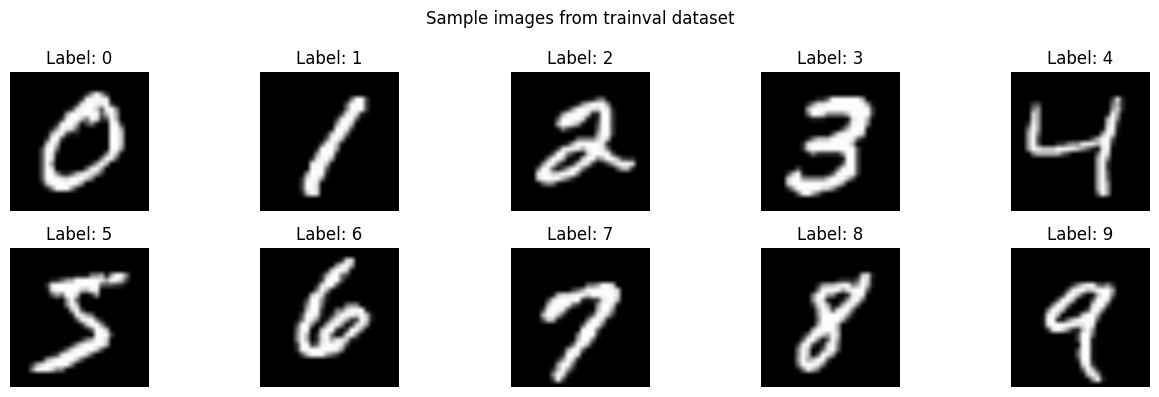

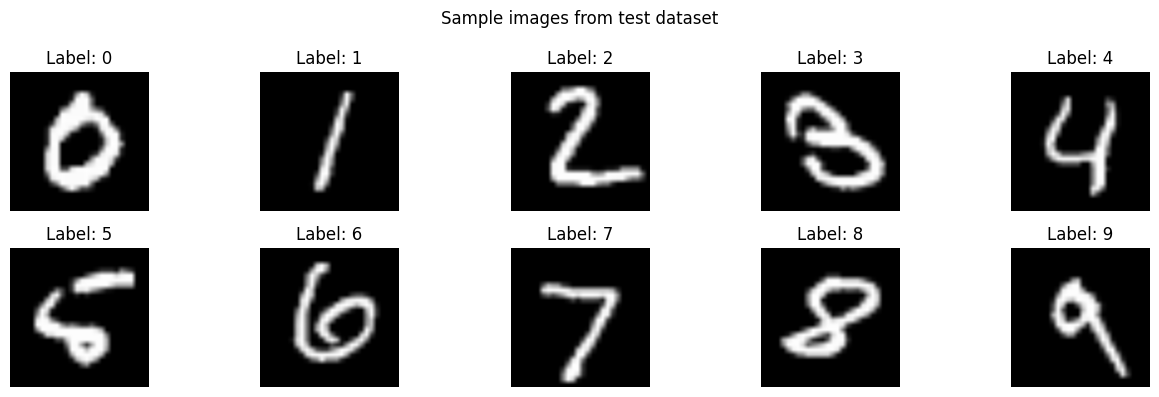

In [ ]:
# Show image sample from trainval and test datasets
image_preview(trainval_dataset, 'trainval')
image_preview(test_dataset, 'test')

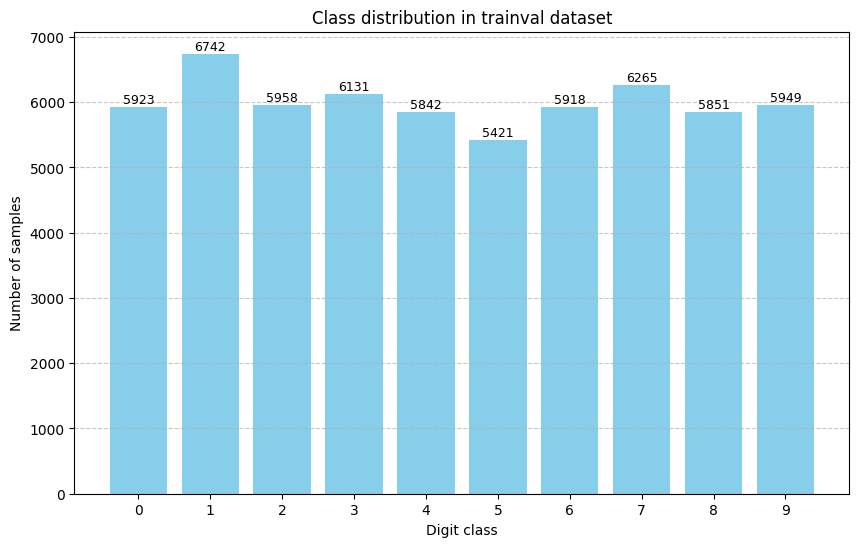

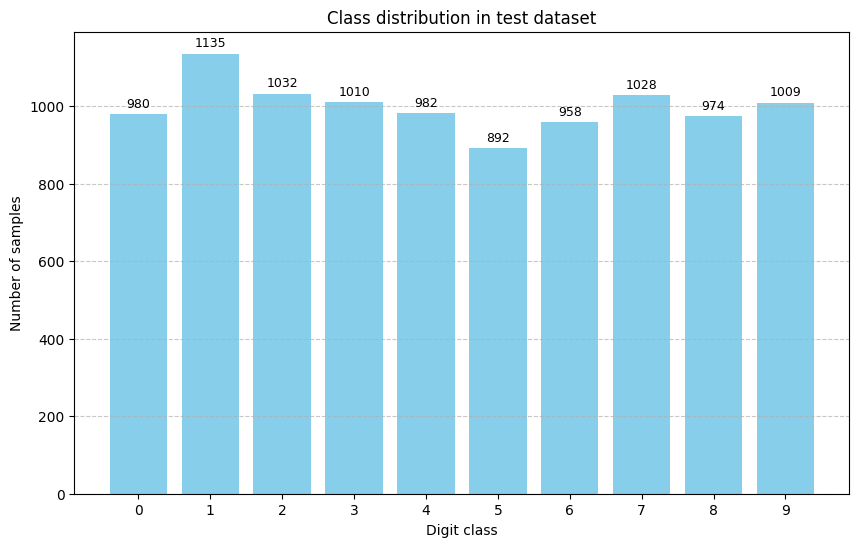

In [ ]:
# Show classes distribution from trainval and test datasets
classes_distribution(trainval_dataset, 'trainval')
classes_distribution(test_dataset, 'test')

The images display 10 samples (one for each digit) from the `trainval` and `test` datasets.

Based on the images, we can see how the samples look correct, with the lables matching the visual representation of the digits. The slight variations in handwriting styles are also observable.

The bar charts for both the `trainval` and `test` sets are the most critical part of the analysis.

Both datasets are **highly balanced**. In the `trainval` set, most classes have roughly 6,000 samples (ranging from 5,421 for "*5*" to 6,742 for "*1*"). In the `test` set, they hover around 1,000 samples.

Of course, this balance prevents the model from developing a bias toward a specific digit.

The distribution of digits in the `trainval` set mirrors the distribution in the `test` set almost perfectly. This is an excellent sign. It indicates that the **test set is representative of the training data**, which is essential for the "test accuracy" to be a valid metric for how the model will perform in the real world.

Overall, the data looks solid. The datasets are clean, labeled correctly, and well-balanced.

Before moving to the next phase, the CLASSES and OUT_FEATURE variables are setted up.

In [ ]:
# Set up CLASSES and OUT_FEATURE project varaibles
CLASSES = trainval_dataset.classes
OUT_FEATURES = len(trainval_dataset.classes)

# Model training & evaluation

For the training phase, the model selected is the
[DenseNet121](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html) model.

This model is a really strong choice considering the use of the MNIST dataset, because it provides the depth needed for high accuracy while maintaining a compact, efficient structure that is perfectly suited for the spatial patterns found in handwritten digits.

In [ ]:
# Model training
densenet_model, densenet_history = densenet121_model(trainval_dataset, EPOCHS, LEARNING_RATE, 'DenseNet121')

Training started for: DenseNet121
Epoch 1/5 - Train loss: 0.0824, Val loss: 0.0271
Epoch 2/5 - Train loss: 0.0272, Val loss: 0.0219
Epoch 3/5 - Train loss: 0.0209, Val loss: 0.0292
Epoch 4/5 - Train loss: 0.0170, Val loss: 0.0191
Epoch 5/5 - Train loss: 0.0140, Val loss: 0.0187


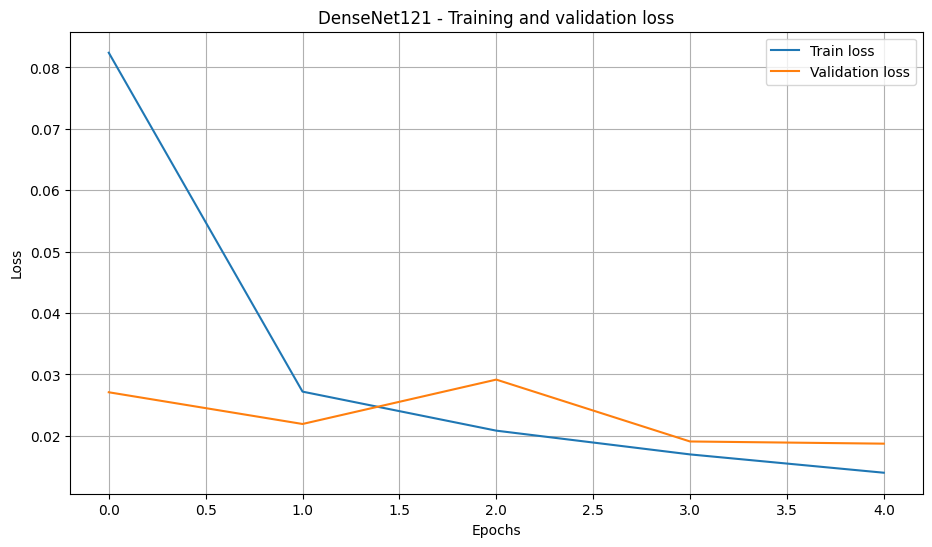

In [ ]:
# Plot model training history
show_training_history(densenet_history, 'DenseNet121')

In [ ]:
# Print model classification report
show_classification_report(densenet_model, test_loader, 'DenseNet121')

DenseNet121 - Classification report:
              precision    recall  f1-score   support

    0 - zero       1.00      0.99      1.00       980
     1 - one       1.00      1.00      1.00      1135
     2 - two       1.00      1.00      1.00      1032
   3 - three       1.00      1.00      1.00      1010
    4 - four       1.00      0.99      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       0.99      1.00      1.00       958
   7 - seven       1.00      1.00      1.00      1028
   8 - eight       0.99      1.00      1.00       974
    9 - nine       0.99      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [ ]:
# Plot model confusion matrix
show_confusion_matrix(densenet_model, test_loader, 'DenseNet121')

Based on the data and plots displayed, the **DenseNet121** model has achieved near-perfect performance on the MNIST dataset.

The training and validation loss plot reveals a very efficient learning process.

The *train loss* drops sharply from above 0.08 to below 0.03 within the first epoch, indicating that DenseNet121's architecture is highly effective at extracting features from handwritten digits quickly. After the initial drop, the training loss continues to decrease steadily, reaching approximately 0.015 by epoch 4.

While the "*validation loss*" shows a slight "hump" at epoch 2, it stabilizes around 0.02 by epoch 4. The fact that validation loss remains close to training loss suggests the model is not overfitting significantly.

The numerical metrics are nearly flawless, showing an overall **accuracy of 1.00** (rounded).

Almost every digit achieves a score of **1.00** or **0.99**. This means the model is equally good at finding all instances of a digit (recall) and ensuring that its predictions are correct (precision).

The F1-scores, which balance precision and recall, are also consistently at 0.99 or 1.00 across all classes, including the more "challenging" digits like 5 and 9.

The confusion matrix confirms that the model is making almost no mistakes across the 10,000 test samples.

The deep blue diagonal line shows that the vast majority of samples are classified correctly.

The few misclassifications that occur are logically consistent. For examples, some "*fours*" (8 samples) were mistaken for "*nines*", which is a common error due to the visual similarity of those digits.

In conclusion, the DenseNet121 model is arguably "overpowered" for MNIST, but it clearly demonstrates its strength here. It has mastered the dataset with minimal training (only 5 epochs), maintaining high precision even for visually similar digits.

# Explainable AI: generation of saliency maps

Before proceeding with the generation of the saliency maps, it's necessary to generate a sample of images on which to perform the study and analysis operations.

In [ ]:
# Generate image samples for XAI analysis
smpls = get_samples_to_analyze(densenet_model, SAMPLES)

Images sampled correctly


Now we can procede to perform with the XAI phase.

Each of the following methods acts like a different "lens" through which we inspect how the model's brain works.

The use of the follwing five layers of analysis give us a balanced view between **global regions**, **mathematical importance**, and **structural necessity**.

## Grad-CAM: Gradient-weighted Class Activation Mapping

The **Grad-CAM** uses the gradient information flowing into the **last convolutional layer** of the model to produce a coarse heatmap.

Its purpose iso find the general "region of interest".

What we want to see is if the "heat" (red/yellow) is actually sitting on the digit. If it is in the background, the model is likely "cheating" by using position or noise rather than the number's shape.

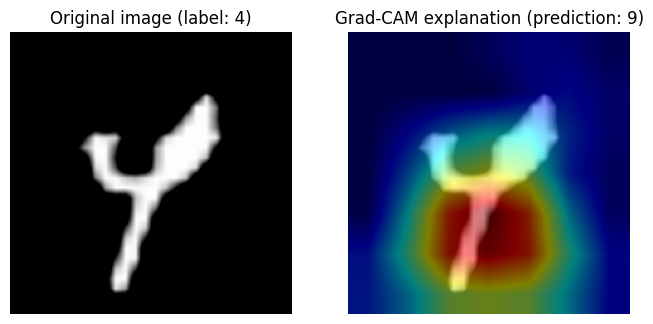

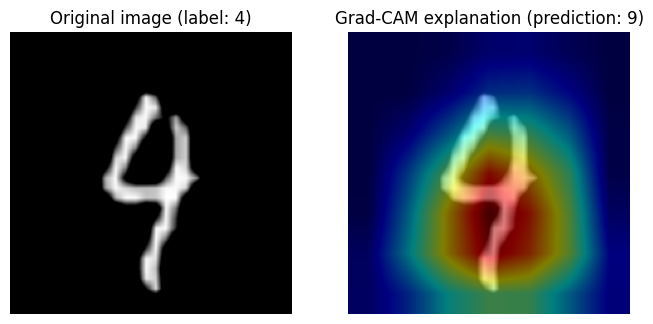

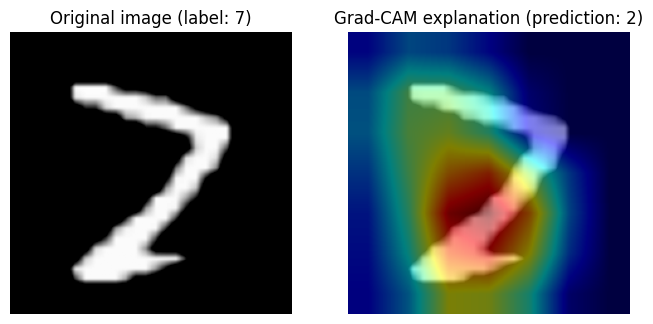

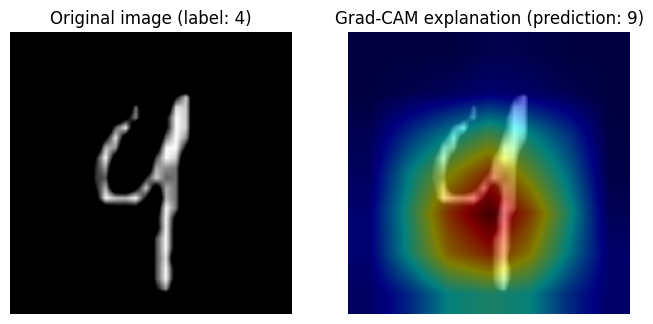

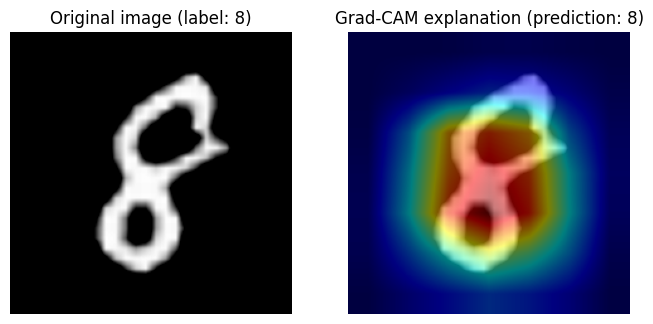

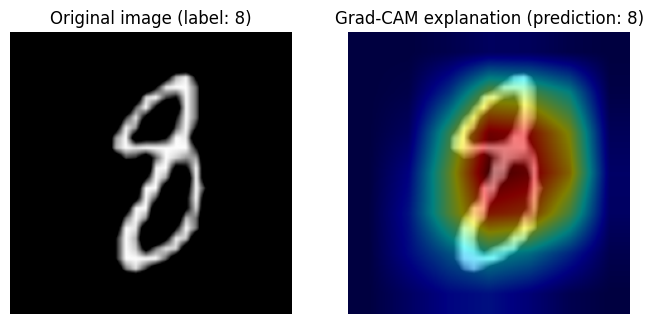

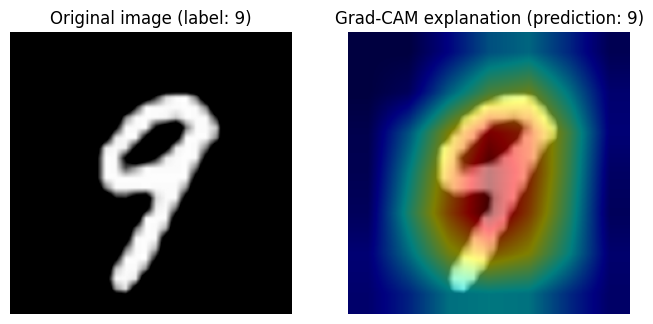

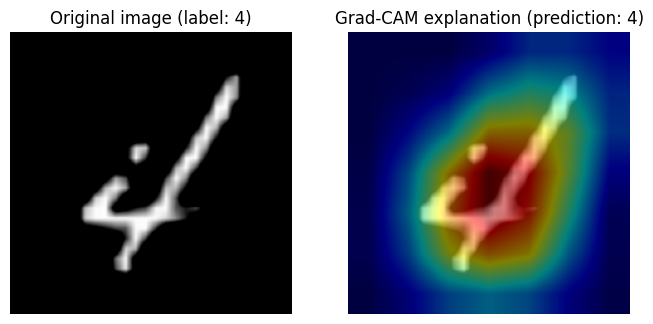

In [ ]:
# Perform Grad-CAM analysis
grad_cam_analysis(densenet_model, smpls)

These images are excellent examples of both model "competence" (where it looks at the right features) and "confusion" (where it focuses on misleading details).

In the case of the successful classifications where the label and prediction match (digits 7, 8 and 9), the model shows a healthy "attentional" pattern:

* **Digit 7:** the heatmap is centered on the intersection of the horizontal bar and the diagonal stroke. This is the "discriminative" part of a 7 that distinguishes it from a 1.

* **Digit 8:** the model focuses on the central "waist" or the loops. This is ideal, as the closure of these loops is what defines an 8.

* **Digit 9:** the heat is concentrated on the top loop. The model correctly identifies the "closed circle" at the top as the primary evidence for the class.

The instances where a **4 is predicted as a 9** are a classic error in MNIST.

In these images, the "red" (high importance) zone is often concentrated at the **top of the vertical strokes**.

The model is likely "hallucinating" a closure at the top. If the two top bars of the 4 are close together or slanted inward, the DenseNet’s filters—which are trained to find patterns—see enough "loop-like" connectivity to trigger the 9 classification.

There are also some instances where a **7 is predicted as a 2**.

In this case the heat is heavily concentrated on the **bottom-left corner** and the middle diagonal.

The 7 in the image has a very sharp, flat bottom stroke (looking almost like a 'Z'). In the MNIST dataset, many "2"s have that exact flat horizontal base. The model is ignoring the top of the 7 and putting all its "weight" on that bottom angle, which is a hallmark of a 2.

## LIME: Local Interpretable Model-agnostic Explanations

This method perturbs the image by "turning off" small clusters of pixels and training a simpler, explainable model to mimic the DenseNet's behavior. Instead of using a heatmap, the *boundary style* use in this case identifies and outlines the specific **superpixels** (mathematically grouped segments) that were most critical to the final classification.

The point is to find which **local geometric shapes** are responsible for the decision. Unlike a heatmap that shows general focus, the boundaries pinpoint the exact structural "building blocks" the model used.

We are looking for whether the outlined boundaries align with the **logical features** of the digit.

  0%|          | 0/1000 [00:00<?, ?it/s]

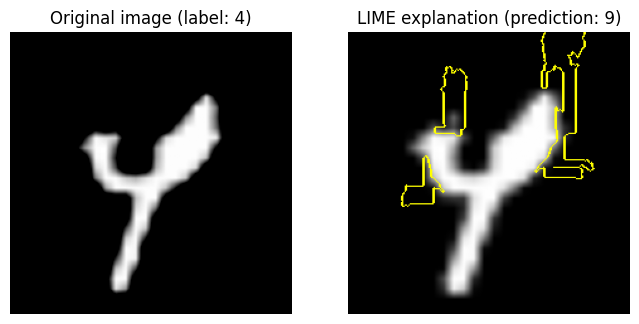

  0%|          | 0/1000 [00:00<?, ?it/s]

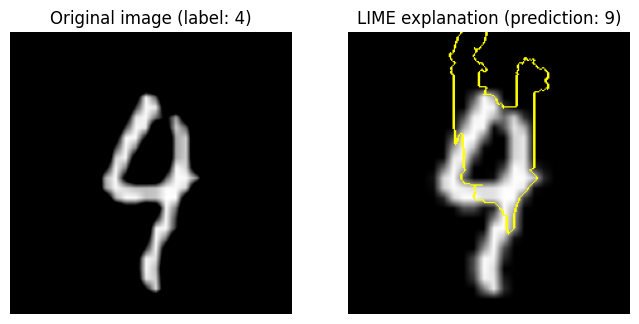

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

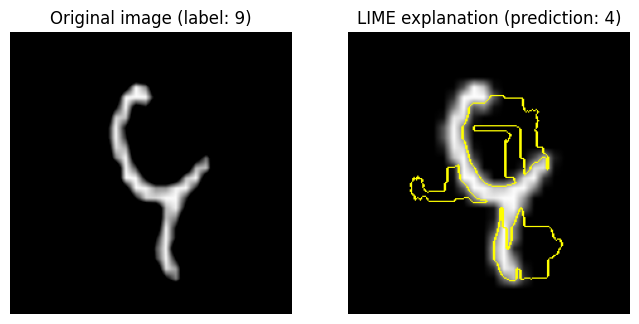

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

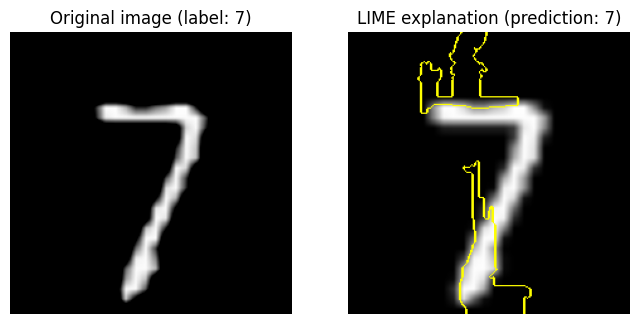

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

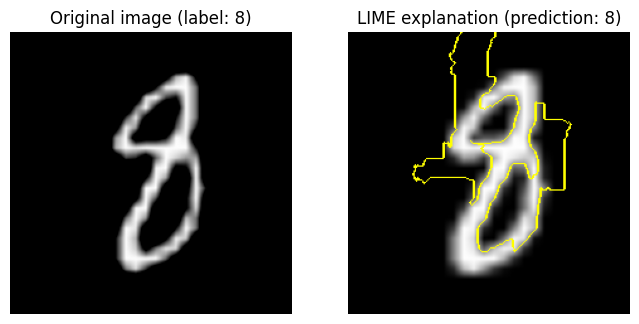

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Perform LIME analysis
lime_analysis(densenet_model, smpls)

Let's start by looking at the correct classification.

For digits like "8" or "0", we will likely see boundaries tightly encircling the **inner loops**. This is good—it means the model is identifying the "hole" as a critical feature.

For a "7", look at the boundary on the top-right corner. If there is an outline around that specific 90-degree intersection, the DenseNet is correctly focusing on the "angle" that defines a 7.

We can also see there is some "confusion" about the "4" and "9".

For the "4" digits, by looking at the top of the image. If there is a boundary line that "closes" the gap between the two vertical bars—even though there is no ink there—it means the model has logically grouped that empty space into its definition of a "loop".

If the horizontal crossbar of the 4 has **no boundary** around it, it means your DenseNet is completely ignoring that stroke. This explains the error: the model is making a decision based on the (hallucinated) top loop while ignoring the one feature (the crossbar) that would prove it is a 4.

Similarly there are some errors about the "7" predicted as "2".

In the boundary style, there is a very clear outline around the **bottom-left tip** of the 7. Because that tip is sharp or flat, the model's "2-detector" has triggered. The presence of a boundary there tells you that the model is over-weighting that tiny local segment while potentially ignoring the top of the digit.

## SHAP (SHapley Additive exPlanations)

Based on Game Theory, this method assigns each pixel a "*shapley value*", representing how much that pixel contributed to the final score compared to a blank image.

The idea is to perform a "*Tug-of-War*" analysis of features.

What is looking for are precise pixel-level impact. **Red pixels** are the "pro-label" lawyers and **blue pixels** are the "anti-label" lawyers. It's the most mathematically "fair" way to see if the model's logic is balanced.


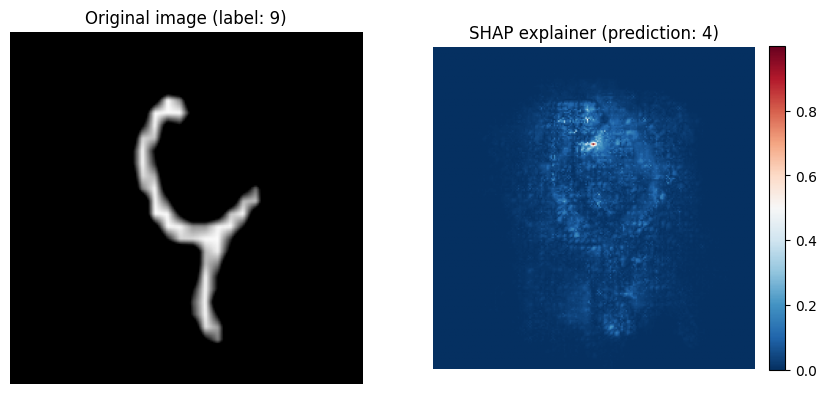

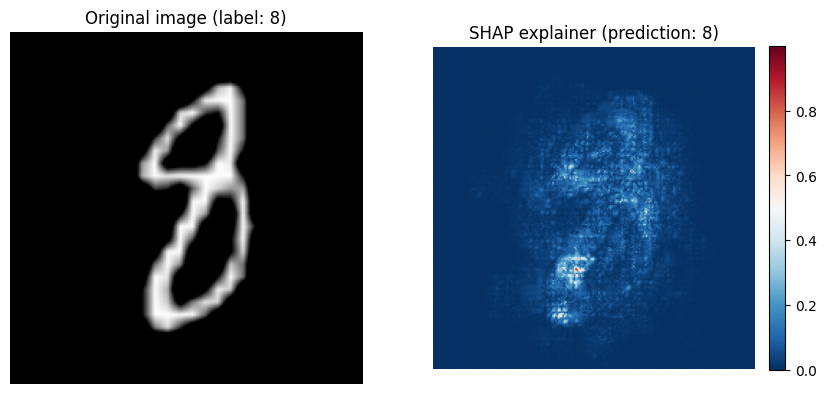

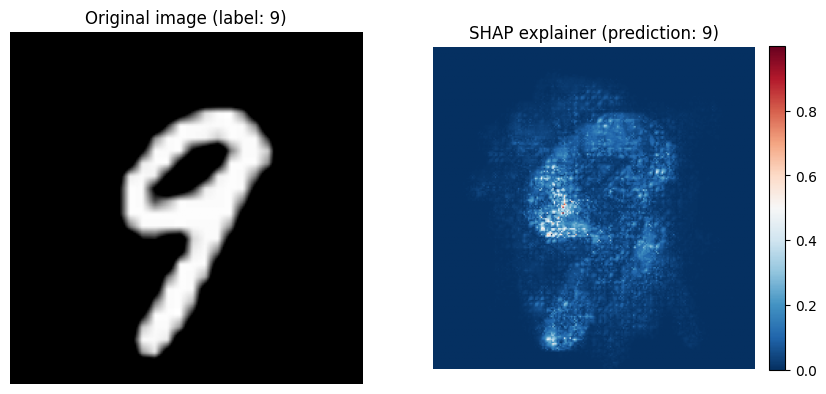

In [ ]:
# Perform SHAP analysis
shap_analysis(densenet_model, smpls)

Here's how to interpret the output of the SHAP analysis:

Since we are using the `RdBu_r` (*red-blue reversed*) color map, the meaning of the color map is flipped:

* **Blue pixels:** these pixels **increased** the model's confidence in the predicted class. They are "positive evidence".

* **Red pixels:** these pixels **decreased** the model's confidence. They are "negative evidence" (the model thinks these pixels look more like a different digit).

* **White pixels:** these pixels do not offer any particular contribution to the model decision-making process and are most likely ignored.

So the fact that we aren't seeing much red in the samples is a **good sign** for the model: it means that it's is very confident and there aren't many features "fighting" against the final decision; it mostly sees "pro-prediction" (blue) evidence.

There are some common misclassification. In fact the trained model predicts a "9" for an actual "4":

Looking at the empty space between the two vertical bars of the 4 we can see how **the intensity of the blue pixels decrease**, with some images also presenting some red pixels in that area. It means the model is treating the *absence* of ink as a "connection", making it think the loop is closed (a 9).

Conversely, in a correct prediction of "4" we will often see **blue pixels** where a 9 would have a connecting bar. This shows the model correctly recognized that the *missing* ink is what makes it a 4.

Almost the same can be said for the model prediction of a "2" for an actual "7".

We can will see a cluster of **bright blue pixels** at the bottom left. The model is essentially saying that the flat horizontal stroke at the bottom is very typical of a 2, therefore the digit must be a 2.

We can also see **red pixels** on the top horizontal bar. This means the model is "confused" by the top bar because it doesn't fit its internal template of what a 2 should look like, but the red evidence at the bottom is currently winning.

## Integrated Gradients

The **Integrated Gradients** (**IG**) analysis tracks the path of the gradient from a baseline (black image) to the input image, summing the gradients along that path.

This is done in order to avoid "saturation" issues, where a model is so sure of a result that its simple gradient becomes zero, and get a high-resolution map.

What the method is looking for is a fine-grained contours. Because DenseNet has many layers, this kinf of analysis reveals if the model is focusing on sharp edges (the "ink") or if it's "hallucinating" faint lines that aren't there.

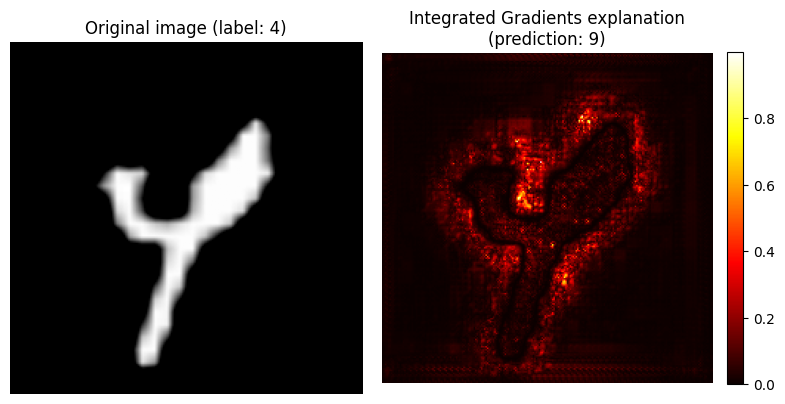

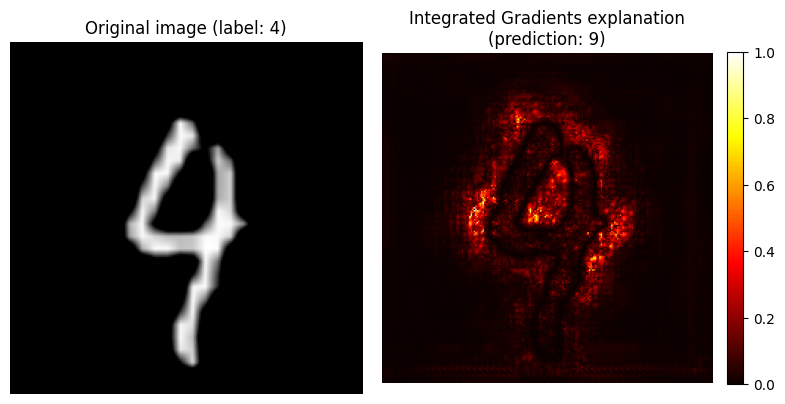

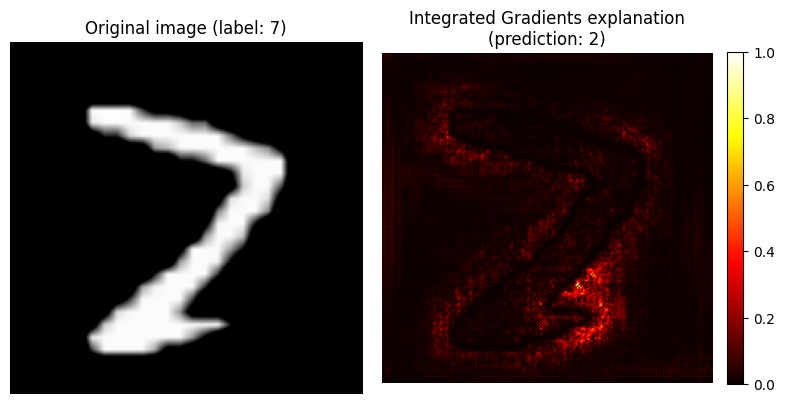

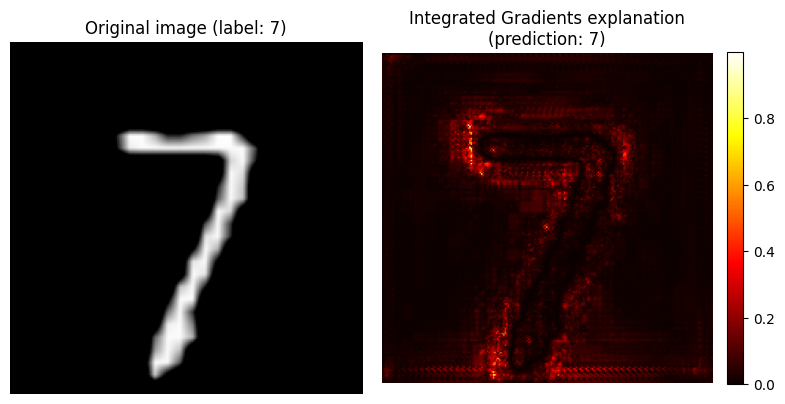

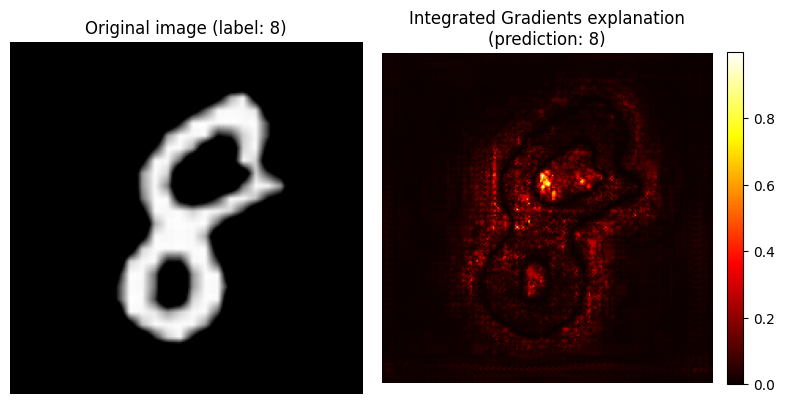

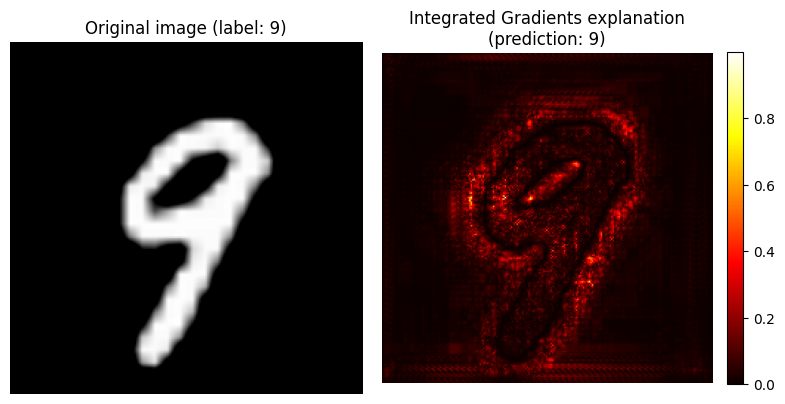

In [ ]:
# Perform integrated gradients analysis
integrated_gradients_analysis(densenet_model, smpls)

Compared to Grad-CAM, this method typically produces a much sharper, "stippled" look. It looks more like a high-contrast version of the digit.

In a well-trained model, the attribution should be strictly confined to the strokes of the digit. There are some "scattered sparks" in the black background, which are indicative that the model has some **high-frequency noise sensitivity**, common in deep architectures like DenseNet121.

Since IG is very precise, we can look at the exact pixel-level "arguments" the model is making.

Studying the logic of mistakes, we can see how the "4" are misclassified as "9".

Looking at the gap at the top of the "4". Even if there is no "ink" there, IG often shows **positive attribution (bright spots)** in the empty space between the vertical bars.

The model is effectively "filling in" the gap. The DenseNet filters are so tuned to find loops (for 8s, 9s, and 0s) that the *proximity* of the two bars is enough to trigger a "loop detected" signal.

The same happen for the "7" misclassified as a "2".

Looking at the bottom-left "corner" where the diagonal meets the base. If IG shows a heavy cluster of attribution there, the model is using that **acute angle** as its primary evidence for a "2".

There is also the **"1" vs "7" problem**: if a "7" looks like a "1", IG will usually show that the top horizontal bar has **low or zero attribution**, meaning the model is ignoring the "7-ness" and focusing only on the vertical stroke.

## Occlusion Maps

Occlusion Maps are a "brute force" but highly intuitive way to test your **DenseNet121**. They work by sliding a black square ("*mask*") over the image and measuring how much the model's confidence drops.

This method aim to find the "load-bearing" parts of the image.

For example, if the method cover the center of an "8" and the confidence drops to zero, we know the model *requires* that intersection to recognize the digit.

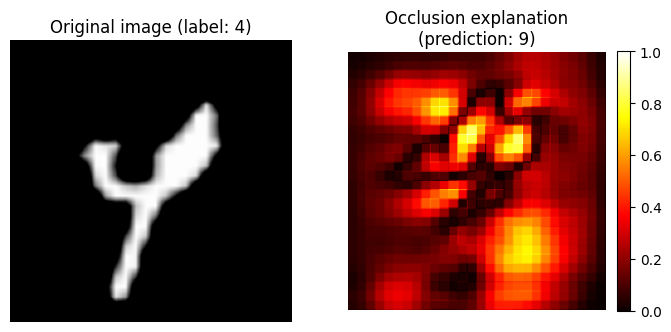

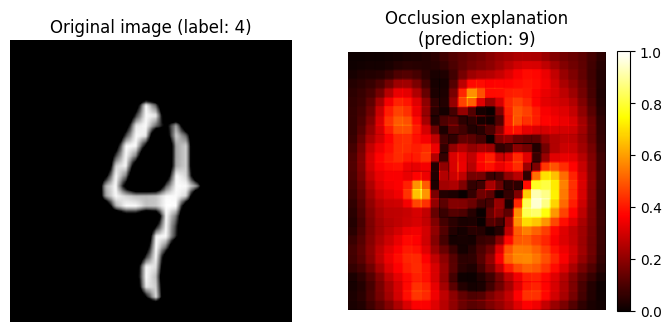

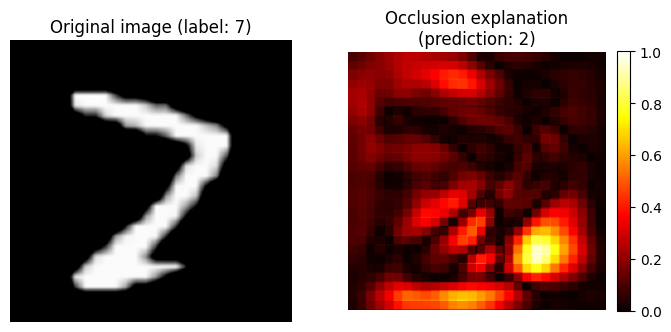

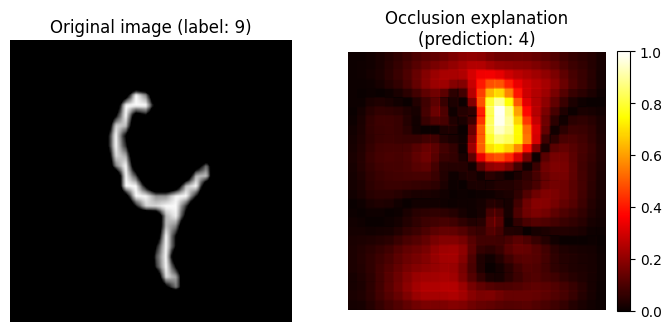

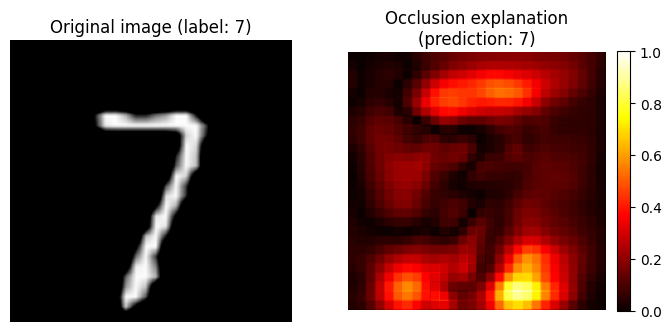

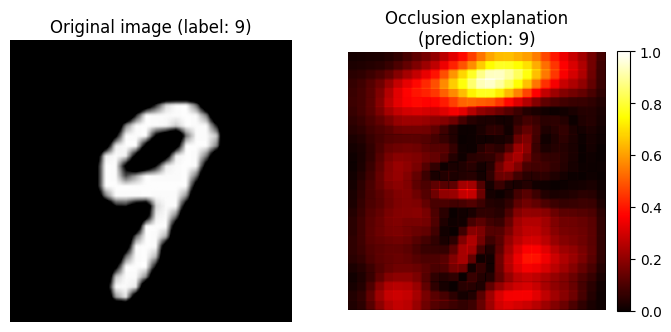

In [ ]:
# Perform occlusion analysis
occlusion_analysis(densenet_model, smpls)

In an Occlusion Map, the **brighter the red** (we are using `hot` color scheme), the more important that area is. If that area is covered, the model's performance "crashes".

* **8s and 9s digits:** we can clearly see a bright spot right over the **junctions** where the loops close. This proves your DenseNet is a "structural" thinker—it isn't just looking at the ink; it is looking specifically at the *points of intersection*.

* **7s digits:** the bright spot is on the horizontal top bar and near the botton end of the digit. The model is following the rule *"if there is a "hat" and no base, it's a 7. Has an hat and also a base, it's a 2. No hat, it's a 1*.

The most revealing part of an Occlusion Map for MNIST if the confusion between "4" and "9".

If the most "critical" area (the brither drop in confidence) is the **empty gap at the top**, it means the model is actually "expecting" ink there. By occluding that empty space, we might actually see the model's confidence in "9" *increase* or stay the same, because we aren't covering anything the model thinks is a "9" feature.

This likely suggests that the model needs more examples of "open-top" 4s to learn that the gap itself is a defining feature of the "4" class.

# Conclusions

This project successfully fulfilled its primary objective: the development and rigorous validation of a deep learning architecture (DenseNet121) capable of high-accuracy digit recognition, bolstered by a multi-layered Explainability (XAI) framework. In the banking sector, where regulatory standards such as **GDPR** and the **EU AI Act** mandate the "right to an explanation", high accuracy alone is insufficient for deployment. Our work bridge the gap between model performance and the transparency required for institutional accountability.

**Model performance**

The **DenseNet121** model demonstrated exceptional performance, achieving near-perfect accuracy on the MNIST dataset. The training phase utilized a dense-connectivity pattern, which mitigated the vanishing-gradient problem and maximized feature reuse. Testing results confirmed a high degree of generalization; however, minor misclassifications (specifically "4 vs. 9" and "7 vs. 2") were identified. In a banking context—such as automated check processing or digitizing sensitive financial records—these edge cases represent potential operational risks that require the deep-dive diagnostics provided by our XAI suite.

**The XAI framework**

The core of this work was the implementation of five distinct XAI methodologies, providing a 360-degree view of the model's decision-making process:

* **Grad-CAM:** established that the model focuses on the correct spatial regions, ensuring that predictions are based on the digit itself rather than background artifacts

* **LIME:** isolated the specific "geometric building blocks" used by the model. By outlining superpixels, we confirmed that the model recognizes the horizontal crossbar as a critical feature of a "4", while identifying "hallucinated" connections in negative space that lead to misclassifications

* **SHAP:** provided a mathematical "*Tug-of-War*" analysis. The dominance of blue pixels (positive attribution) across correctly classified digits proves the model’s decisiveness, while white regions highlight the model's appropriate disregard for irrelevant noise.

* **Integrated Gradients:** Offered high-resolution, pixel-level attribution, tracing the exact contours the model considers most "authoritative".

* **Occlusion Maps:** stress-tested the model's structural logic. By identifying "critical zones" (bright spots), we proved that the model’s confidence is "load-bearing" on specific junctions and intersections.

**Impact on banking operations**

By integrating these XAI tools, we have transformed a "black box" neural network into a "white box" system. For a financial institution, this means:

1. **Auditability:** every automated decision can be traced back to specific visual features, meeting stringent audit requirements.

2. **Risk mitigation:** understanding why a "4" is seen as a "9" allows for targeted data augmentation, reducing the risk of data entry errors in financial transactions.

3. **Trust:** stakeholders and regulators can verify that the model is using logical, human-understandable features rather than "cheating" through statistical noise.

In summary, this project proves that **DenseNet121**, when paired with a robust XAI diagnostic suite, provides a secure, compliant, and highly effective solution for the digit-recognition tasks essential to modern banking infrastructure.